Some resources:
- https://towardsdatascience.com/sentence-correctness-classifier-using-transfer-learning-with-huggingface-bert-8884795ba5ca


In [4]:
import json
import conllu
from udapi.core.dualdict import DualDict

path = "../../UD/no_bokmaal-ud-dev.conllu"
# read conll data:

with open(path, "r", encoding="utf-8") as f:
    data = conllu.parse(f.read())

In [5]:
# for each sentence, extract:
# tokenform, POS, morphological features, head, dependency relation
from dataclasses import dataclass

morph_keys = ['Abbr', 'Animacy', 'Case', 'Definite', 'Degree', 'Gender', 'Mood', 'NumType', 'Number', 'Person', 'Polarity', 'Poss', 'PronType', 'Reflex', 'Tense', 'VerbForm', 'Voice']

@dataclass
class Token:
    sentence_id: int
    tokenform: str
    pos: str
    morph: DualDict
    dep: str
    head: int
    head_pos: str
    head_dist: int
    
    def morph_transform(self):
        # create a field for each of the morph keys, and add the value if it exists
        for key in morph_keys:
            if self.morph and key in self.morph:
                setattr(self, key, self.morph[key])
            else:
                setattr(self, key, None)

    def __str__(self) -> str:
        return f"\
        TOKEN: {self.tokenform}, {self.pos}\t{self.morph}\n \
        - HEAD: Relation: {self.dep} -> {self.head}, {self.head_pos}, dist: {self.head_dist} \
        "

    def to_dict(self):
        # generate a dict with all "morph_keys" as keys
        morph_dict = {}
        for key in morph_keys:
            morph_dict[key] = getattr(self, key)
        # add all self-attributes to a token dict:
        token_dict = {
            "sentence_id": self.sentence_id,
            "tokenform": self.tokenform,
            "pos": self.pos,
            "dep": self.dep,
            "head": self.head,
            "head_pos": self.head_pos,
            "head_dist": self.head_dist
        }
        # add the morphological features to the dict
        token_dict.update(morph_dict)
        return token_dict
        
tokens = []
for sentence in data:
    for token in sentence:
        head = token["head"]
        head_pos = sentence[head - 1]["upostag"]
        head_dist = head - token["id"]
        token = Token(
            sentence_id=sentence.metadata["sent_id"],
            tokenform=token["form"],
            pos=token["upostag"],
            morph=token["feats"],
            dep=token["deprel"],
            head=head,
            head_pos=head_pos,
            head_dist=head_dist
        )
        token.morph_transform()
        tokens.append(token)

In [6]:
# place all tokens in a df:
import pandas as pd

df = pd.DataFrame([token.to_dict() for token in tokens])
# add a "grammatical": True column
df = df.assign(grammatical=True)
print(df.shape)
df.head()

(36369, 25)


,sentence_id,tokenform,pos,dep,head,head_pos,head_dist,Abbr,Animacy,Case,...,Number,Person,Polarity,Poss,PronType,Reflex,Tense,VerbForm,Voice,grammatical
0,015697,Dommer,NOUN,nmod,2,PROPN,1,None,None,None,...,Sing,None,None,None,None,None,None,None,None,True
1,015697,Finn,PROPN,nsubj,4,VERB,2,None,None,None,...,None,None,None,None,None,None,None,None,None,True
2,015697,Eilertsen,PROPN,flat:name,2,PROPN,-1,None,None,None,...,None,None,None,None,None,None,None,None,None,True
3,015697,avstår,VERB,root,0,PUNCT,-4,None,None,None,...,None,None,None,None,None,None,Pres,Fin,None,True
4,015697,",",PUNCT,punct,7,ADJ,2,None,None,None,...,None,None,None,None,None,None,None,None,None,True


In [7]:
# create dummies for all POS, DEP, HEAD_POS and morphological features
df = pd.get_dummies(df, columns=["pos", "dep", "head_pos"])
for key in morph_keys:
    df = pd.get_dummies(df, columns=[key])
df.head(0).T

""
sentence_id
tokenform
head
head_dist
grammatical
...
Tense_Pres
VerbForm_Fin
VerbForm_Inf
VerbForm_Part


In [8]:
df.head()

,sentence_id,tokenform,head,head_dist,grammatical,pos_ADJ,pos_ADP,pos_ADV,pos_AUX,pos_CCONJ,...,PronType_Rcp,PronType_Rel,PronType_Tot,Reflex_Yes,Tense_Past,Tense_Pres,VerbForm_Fin,VerbForm_Inf,VerbForm_Part,Voice_Pass
0,015697,Dommer,2,1,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,015697,Finn,4,2,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,015697,Eilertsen,2,-1,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,015697,avstår,0,-4,True,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,015697,",",7,2,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# 1. make all columns lowercase
df = df.rename(columns=lambda x: x.lower())
# 2. sort the values of the df columns
df = df.sort_index(axis=1)
df.head()

,abbr_yes,animacy_hum,case_acc,case_gen,case_nom,definite_def,definite_ind,degree_cmp,degree_pos,degree_sup,...,prontype_tot,reflex_yes,sentence_id,tense_past,tense_pres,tokenform,verbform_fin,verbform_inf,verbform_part,voice_pass
0,0,0,0,0,0,0,1,0,0,0,...,0,0,015697,0,0,Dommer,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,015697,0,0,Finn,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,015697,0,0,Eilertsen,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,015697,0,1,avstår,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,015697,0,0,",",0,0,0,0


In [10]:
# remove tokenform:
df.drop("tokenform", axis=1, inplace=True)

In [11]:
# group by sentence_id 
sentences = []
for name, group in df.groupby("sentence_id"):
    sentences.append(group)
sentences[0]

,abbr_yes,animacy_hum,case_acc,case_gen,case_nom,definite_def,definite_ind,degree_cmp,degree_pos,degree_sup,...,prontype_rel,prontype_tot,reflex_yes,sentence_id,tense_past,tense_pres,verbform_fin,verbform_inf,verbform_part,voice_pass
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,015697,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,015697,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,015697,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,015697,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,015697,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,...,0,0,0,015697,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,1,0,...,0,0,0,015697,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,015697,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,015697,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,015697,0,0,0,0,0,0


In [12]:
# find subj/obj features:
# subj_obj = [f for f in df.columns if "subj" in f or "obj" in f]
# subj_obj

subj = [f for f in df.columns if "subj" in f]
obj = [f for f in df.columns if "obj" in f]
subjobj = subj + obj

In [13]:
subjobj

['dep_csubj',
 'dep_csubj:pass',
 'dep_nsubj',
 'dep_nsubj:pass',
 'dep_iobj',
 'dep_obj']

In [14]:
# df = df[subjobj + ["tokenform", "sentence_id"]]
# df.head()

In [15]:
# force print all columns:
pd.set_option("display.max_columns", None)

In [16]:
# create a de-grammaticalized version, a ratio of 3:1 wrong:correct
def make_incorrect(sentence, level=0):
    # on level 0: shuffle all words
    # level 1: swap subjects and objects (nsubj, obj)
    # elif level == 1:
    #     new_sent = []
    #     # randomly shuffle the rows that have a 1 at either of the subj/obj features
    #     subj_rows = sentence[sentence[subj].sum(axis=1) > 0]
    #     obj_rows = sentence[sentence[obj].sum(axis=1) > 0]
    #     # shuffle 
    return sentence.sample(frac=1).assign(grammatical=False)

def build_incorrect_sents(sentence, N=10):
    incorrect = []
    for _ in range(N):
        bad_sent = make_incorrect(sentence)
        incorrect.append(bad_sent)
    # # make 10 almost correct versions!
    # for _ in range(10):
    #     pass
    # convert to df
    # return pd.concat(incorrect)
    return incorrect

In [17]:
make_incorrect(sentences[1])

,abbr_yes,animacy_hum,case_acc,case_gen,case_nom,definite_def,definite_ind,degree_cmp,degree_pos,degree_sup,dep_acl,dep_acl:cleft,dep_acl:relcl,dep_advcl,dep_advmod,dep_amod,dep_appos,dep_aux,dep_aux:pass,dep_case,dep_cc,dep_ccomp,dep_compound,dep_compound:prt,dep_conj,dep_cop,dep_csubj,dep_csubj:pass,dep_det,dep_discourse,dep_expl,dep_flat:foreign,dep_flat:name,dep_iobj,dep_mark,dep_nmod,dep_nsubj,dep_nsubj:pass,dep_nummod,dep_obj,dep_obl,dep_orphan,dep_parataxis,dep_punct,dep_reparandum,dep_root,dep_xcomp,gender_fem,"gender_fem,masc",gender_masc,gender_neut,grammatical,head,head_dist,head_pos_adj,head_pos_adp,head_pos_adv,head_pos_aux,head_pos_cconj,head_pos_det,head_pos_intj,head_pos_noun,head_pos_num,head_pos_part,head_pos_pron,head_pos_propn,head_pos_punct,head_pos_sconj,head_pos_verb,head_pos_x,mood_imp,mood_ind,number_plur,number_sing,numtype_card,person_1,person_2,person_3,polarity_neg,pos_adj,pos_adp,pos_adv,pos_aux,pos_cconj,pos_det,pos_intj,pos_noun,pos_num,pos_part,pos_pron,pos_propn,pos_punct,pos_sconj,pos_sym,pos_verb,pos_x,poss_yes,prontype_art,"prontype_art,prs",prontype_dem,prontype_ind,"prontype_ind,prs",prontype_int,prontype_neg,"prontype_neg,prs",prontype_prs,"prontype_prs,tot",prontype_rcp,prontype_rel,prontype_tot,reflex_yes,sentence_id,tense_past,tense_pres,verbform_fin,verbform_inf,verbform_part,voice_pass
46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,8,-4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,015698,0,0,0,1,0,0
38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,False,2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,015698,0,0,0,1,0,0
52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,False,2,-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,015698,0,0,0,0,0,0
51,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,False,12,-5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,015698,0,0,0,0,0,0
36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,015698,0,1,1,0,0,0
37,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,False,2,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,015698,0,0,0,0,0,0
42,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,False,2,-6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,015698,0,0,0,0,0,0
35,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,False,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,015698,0,0,0,0,0,0
39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,6,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,015698,0,0,0,0,0,0
44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,12,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,015698,0,0,0,0,0,0


In [18]:
# create a df with all incorrect sentences:
# incorrect_df = pd.concat([build_incorrect_sents(sent) for sent in sentences])
# incorrect_df.shape

In [19]:
# group by sentence_id 
# incorrect_sentences = []
# for name, group in incorrect_df.groupby("sentence_id"):
#     incorrect_sentences.append(group)
# incorrect_sentences[0]

In [20]:
# we want to plot the sentence length on average, from the grouped sentences df
type(sentences[0])

pandas.core.frame.DataFrame

<Figure size 1000x500 with 0 Axes>

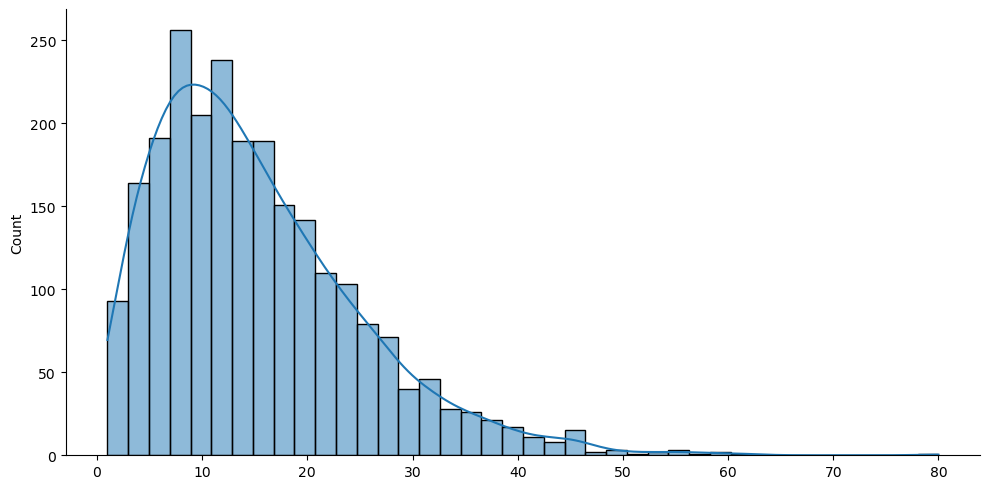

In [21]:
sentence_lens = [len(sent) for sent in sentences]
# plot distribution of sentence lengths
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.displot(sentence_lens, kde=True, bins=40, height=5, aspect=2)
plt.show()


In [22]:
# filter out sentences within the 95th percentile
import numpy as np
perc = np.percentile(sentence_lens, 95)
print(perc)
print(f"Before filtering: {len(sentences)}")
sentences = [sent for sent in sentences if len(sent) <= perc]
print(f"After filtering: {len(sentences)}")

34.0
Before filtering: 2409
After filtering: 2295


<Figure size 1000x500 with 0 Axes>

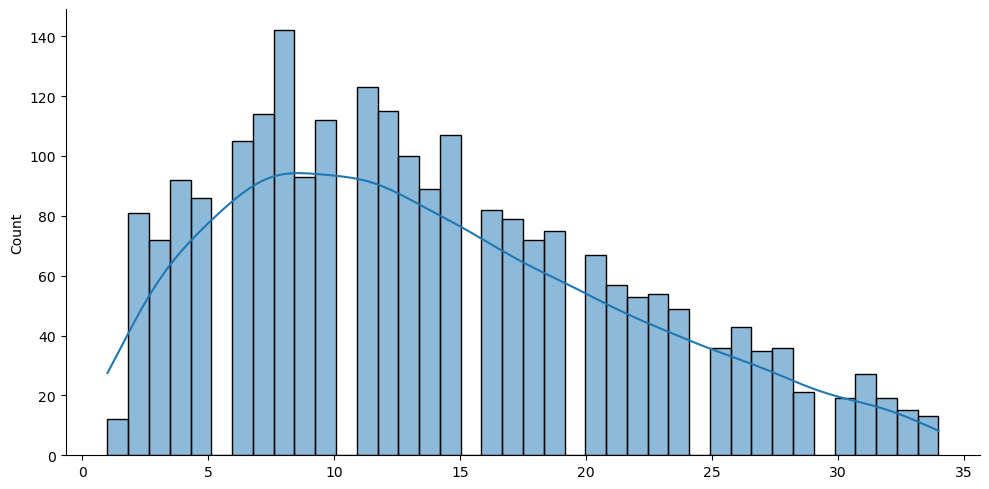

In [23]:
plt.figure(figsize=(10, 5))
lens = [len(sent) for sent in sentences]
sns.displot(lens, kde=True, bins=40, height=5, aspect=2)
plt.show()

In [24]:
MAX_LEN = perc
print(f"Max sentence length: {MAX_LEN}")

Max sentence length: 34.0


In [25]:
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# we now want to classify whether a sentence is grammatically correct using the features we have extracted
# preprocessing of a sentence before training
# remove sentence_id

# MAX_LEN = 34 in this case
def prep_sent(sent: pd.DataFrame):
    sent = sent.drop("sentence_id", axis=1)
    # filter out the grammatical column
    is_grammatical = sent.pop("grammatical")

    # MAX_LEN = len(sent) for debugging
    # right-pad with all-zero values. head and head_dist should be set to -100 to indicate that they are not present
    # create a (n, MAX_LEN) dataframe
    padded = np.zeros((1, int(MAX_LEN), sent.shape[1]))
    # populate with values
    for i, row in enumerate(sent.values):
        padded[0, i, :] = row
    return padded.reshape((int(MAX_LEN), -1)), is_grammatical.values[0]

# sentences = [prep_sent(sent) for sent in sentences]
train, test = train_test_split(sentences, test_size=0.2, random_state=420)
# create a 1:10 ratio of correct:incorrect sentences for train and test
train_aug = []
N_wrong = 3
for sent in train:
    train_aug.append(sent)
    train_aug.extend(build_incorrect_sents(sent, N=N_wrong))
test_aug = []
for sent in tqdm(test):
    test_aug.append(sent)
    test_aug.extend(build_incorrect_sents(sent, N=N_wrong))

print(f"Train: {len(train)} --> {len(train_aug)}")
print(f"Test: {len(test)} --> {len(test_aug)}")

  0%|          | 0/459 [00:00<?, ?it/s]

Train: 1836 --> 7344
Test: 459 --> 1836


In [26]:
# shuffle train and test
train_aug = np.random.permutation(train_aug)
test_aug = np.random.permutation(test_aug)

/var/folders/0k/1bg63zt532nb9d86g5tk_6vh0000gn/T/ipykernel_18122/3858576936.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_aug = np.random.permutation(train_aug)
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/var/folders/0k/1bg63zt532nb9d86g5tk_6vh0000gn/T/ipykernel_18122/3858576936.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must speci

In [24]:
# pad 
train_aug = [prep_sent(sent) for sent in train_aug]
test_aug = [prep_sent(sent) for sent in test_aug]

In [25]:
np.array(train_aug).shape

/var/folders/0k/1bg63zt532nb9d86g5tk_6vh0000gn/T/ipykernel_17611/754009904.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(train_aug).shape


(7344, 2)

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np

X, y = zip(*train_aug)
X_test, y_test = zip(*test_aug)
y = np.array(y, dtype=int)
y_test = np.array(y_test, dtype=int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=420)

X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# print info about X_train, X_val, X_test
print(f"X_train: {type(X_train)}, {len(X_train)}, {type(X_train[0])}, {X_train[0].shape}")
print(f"X_val: {type(X_val)}, {len(X_val)}, {type(X_val[0])}, {X_val[0].shape}")
print(f"X_test: {type(X_test)}, {len(X_test)}, {type(X_test[0])}, {X_test[0].shape}")

X_train: <class 'numpy.ndarray'>, 5875, <class 'numpy.ndarray'>, (34, 116)
X_val: <class 'numpy.ndarray'>, 1469, <class 'numpy.ndarray'>, (34, 116)
X_test: <class 'numpy.ndarray'>, 1836, <class 'numpy.ndarray'>, (34, 116)


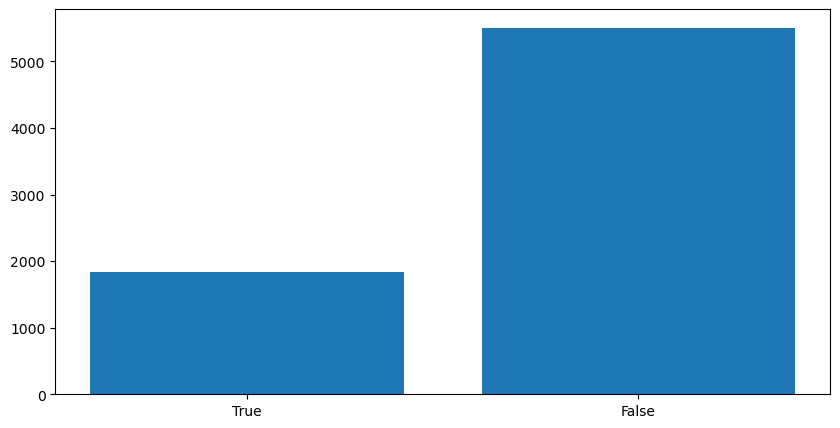

In [27]:
# plot y:
plt.figure(figsize=(10, 5))
plt.bar(["True", "False"], [sum(y), len(y) - sum(y)])
plt.show()

In [28]:
# force jupyter to print entire numpy array
np.set_printoptions(threshold=np.inf)

In [29]:
# for each feature, reduce the dimensionality
# however, we want to take care of temporal dependencies
# as this is sequential data

# thus we add a timestep value of 1 per timestep in the feature space
# [1,2,3,..., 34], so [0,1,3] would be come [0,2,6]

timesteps = np.arange(1, MAX_LEN + 1)
print(timesteps)
def transform_feature_vector(vec): 
    # start by transforming the vector to avoid negative or zero values
    # [-12, -4, 0, 13] -> [0, 8, 12, 25]
    min_value_in_vec = np.min(vec)
    # add min_value and scale by 1 to avoid zeroes
    vec = np.add(vec, 1 + abs(min_value_in_vec))
    # finally, scale by timesteps
    return np.multiply(vec, timesteps)

# sample = X_train[0][1]
# print(sample)
# transform_feature_vector(sample)

# convert the sequences such that each feature (of the 116) contains an array of 34 values, instead of being 3d with (, 34, 116)
def vectorize_features(sentence_grouped_data):
    n_features = sentence_grouped_data[0].shape[-1]
    grouped = []
    for sentence_features in sentence_grouped_data:
        ith_features = []
        for i in range(n_features):
            ith_feature = [token_features[i] for token_features in sentence_features]
            ith_features.append(ith_feature)
        ith = np.asarray(ith_features)
        # transform it:
        ith = transform_feature_vector(ith)
        grouped.append(ith)
    return np.asarray(grouped)

X_train = vectorize_features(X_train)
X_test = vectorize_features(X_test)
X_val = vectorize_features(X_val)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]


In [1]:
X_val[0]

NameError: name 'X_val' is not defined

In [41]:
X_train.shape

(5875, 116, 34)

In [ ]:
import tensorflow as tf

# Define the input shape
input_shape = (116, 34)

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


In [43]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10


: 

: 

In [1084]:
# X_train.shape -> (n_samples, n_features, n_timesteps)
# we want to train a model that takes 116 features, each with 34 timesteps
# then predict whether a sentence is grammatical or not

# create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(64, input_shape=(len(features), MAX_LEN), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
# early stopping
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[es])

plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "val"])
plt.show()

TypeError: Dimension value must be integer or None or have an __index__ method, got value '34.0' with type '<class 'numpy.float64'>'

In [1082]:
# now use a 1D CNN to extract features from the temporal data (the 34 values per feature)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

input_shape = (X_train.shape[0], 1)
print("input:", input_shape)

# define the model architecture
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the model to the data
model.fit(X_train, y_train, epochs=10, batch_size=32)


input: (5875, 1)
Epoch 1/10


ValueError: in user code:

    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 5875, 1), found shape=(None, 116, 34)


# Feature selection with boosting

In [854]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# train a random forest classifier on the training set
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# calculate permutation importance scores for each feature
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

# get the sorted feature importances
sorted_idx = result.importances_mean.argsort()[::-1]

# print the top feature names and their importance scores
for i in sorted_idx:
    print(f"{i+1}. {X_train[:,:,i].name}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [860]:
# from the sorted index, get the feature names
for i in sorted_idx:
    print(i)
    print(features[i])

52
head_dist
51
head
168


IndexError: list index out of range

In [731]:
np.asarray(X_train).shape

# reshape the data from 3d to 2d, so that the vectors of each sentence are concatenated
# 5875,34,116 -> 5875, 34*116

def to_2d(X):
    X_2d = []
    for x in X:
        X_2d.append(x.reshape(-1))
    return np.asarray(X_2d)

to_2d(X_train)[0]

array([0., 0., 0., ..., 0., 0., 0.])

# Set up a NN with pytorch

In [1085]:
from torch.utils.data import TensorDataset, DataLoader

# Convert the data and labels to PyTorch tensors and create DataLoader objects
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [1088]:
# define the model
# RNN with LSTM cells for the encoder
import torch
import torch.nn as nn
from tqdm.auto import tqdm

# Define the hyperparameters and other settings
input_size = X_train[0].shape[-1]
hidden_size = 1024 # Number of hidden units
num_layers = 3 # Number of LSTM layers
num_classes = 2 # Number of output classes (grammatical vs non-grammatical)
learning_rate = 0.0003
batch_size = 128
num_epochs = 5
    
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Forward propagate LSTM
        out, _ = self.rnn(x, (h0, c0))
        # add a dropout layer
        out = nn.Dropout(0.3)(out)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out
    
# model = GrammarNet(input_dim=input_size, hidden_dim=hidden_size, output_dim=num_classes, n_layers=num_layers, dropout=0.5)
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in tqdm(range(num_epochs)):

    # incorporate early stopping
    
    model.train()
    for batch_idx, (data, targets) in tqdm(enumerate(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        # backward
        opt.zero_grad()
        loss.backward()

        # gradient descent or adam step
        opt.step()
    # evaluate on the validation set
    model.eval()
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data, targets) in enumerate(val_loader):
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(f"Epoch {epoch} - accuracy: {num_correct/num_samples}")

Trainable parameters: 21137410


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

RuntimeError: expected scalar type Double but found Float

In [699]:
# validate on the test set:
with torch.no_grad():
    num_correct = 0
    num_samples = 0
    for batch_idx, (data, targets) in enumerate(test_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Test accuracy: {num_correct/num_samples}")

Test accuracy: 0.9656862616539001


In [700]:
# an end-to-end application with spaCy to derive the features
features = df.columns.drop(['sentence_id', 'grammatical']).values.tolist()

In [701]:
import spacy

nlp = spacy.load("nb_core_news_md")

In [702]:
normal_feats = []
morph_feats = []
pos_feats = []
dep_feats = []
for f in features:
    if "pos_" in f:
        pos_feats.append(f)
    elif "dep_" in f:
        dep_feats.append(f)
    elif f in ["head", "head_dist"]:
        normal_feats.append(f)
    else:
        morph_feats.append(f)

print(f"Normal features: {normal_feats}")
print(f"Morphological features: {morph_feats}")
print(f"POS features: {pos_feats}")
print(f"Dependency features: {dep_feats}")

Normal features: ['head', 'head_dist']
Morphological features: ['abbr_yes', 'animacy_hum', 'case_acc', 'case_gen', 'case_nom', 'definite_def', 'definite_ind', 'degree_cmp', 'degree_pos', 'degree_sup', 'gender_fem', 'gender_fem,masc', 'gender_masc', 'gender_neut', 'mood_imp', 'mood_ind', 'number_plur', 'number_sing', 'numtype_card', 'person_1', 'person_2', 'person_3', 'polarity_neg', 'poss_yes', 'prontype_art', 'prontype_art,prs', 'prontype_dem', 'prontype_ind', 'prontype_ind,prs', 'prontype_int', 'prontype_neg', 'prontype_neg,prs', 'prontype_prs', 'prontype_prs,tot', 'prontype_rcp', 'prontype_rel', 'prontype_tot', 'reflex_yes', 'tense_past', 'tense_pres', 'verbform_fin', 'verbform_inf', 'verbform_part', 'voice_pass']
POS features: ['head_pos_adj', 'head_pos_adp', 'head_pos_adv', 'head_pos_aux', 'head_pos_cconj', 'head_pos_det', 'head_pos_intj', 'head_pos_noun', 'head_pos_num', 'head_pos_part', 'head_pos_pron', 'head_pos_propn', 'head_pos_punct', 'head_pos_sconj', 'head_pos_verb', 'head

In [703]:
# fetch all the features for a given sentence
from udapi.core.dualdict import DualDict
s = "Bakgrunnen for den streiken kom etter at LO-leder Peggy Hansen sa nei til Riksmeklerens skisse søndag. NHO skal ha godtatt denne."
doc = nlp(s)


In [704]:
# extract features
def get_token_features(token):
    head = token.head.i
    head_pos = token.head.pos_
    head_dist = token.i - head
    pos = token.pos_
    dep = token.dep_
    morph = token.morph
    dd = DualDict(str(morph))
    dd._deserialize_if_empty()
    # convert morph features from Key: Value to key_value
    parsed_morph = []
    for k, v in dd._dict.items():
        _id = f"{k}_{v}".lower()
        parsed_morph.append(_id)

    # create a feature set with the same keys as the dataframe
    onehotted_feats = { k: 0 for k in features }
    onehotted_feats["head"] = head
    onehotted_feats["head_dist"] = head_dist

    for feature in morph_feats:
        hot = 1 if feature in parsed_morph else 0
        onehotted_feats[feature] = hot

    for pos in pos_feats:
        # pos_ADV, pos_AUX, ...
        if pos.startswith("head_"):
            hot = int(f"head_pos_{head_pos}".lower() == pos)
        else:
            hot = int(f"pos_{token.pos_}".lower() == pos)
        onehotted_feats[pos] = hot

    for dep in dep_feats:
        # 'dep_acl', 'dep_acl:cleft', 'dep_acl:relcl', ...
        onehotted_feats[dep] = int(f"dep_{token.dep_}" == dep)

    # return np.array(list(onehotted_feats.values()))
    # return a list of values
    return np.asarray(list(onehotted_feats.values()))

def get_sentence_vector(doc_sent, MAX_LEN=34):
    doc_feats = [get_token_features(token) for token in doc_sent]
    FEATURE_LEN = len(doc_feats[0])

    # pad up to MAX_LEN (34) with zeros
    padded = np.zeros((1, int(MAX_LEN), int(FEATURE_LEN)))
    # populate with values
    for i, row in enumerate(doc_feats):
        padded[0, i, :] = row
    # reshape and return
    return padded.reshape((int(MAX_LEN), -1))


doc_feats = get_sentence_vector(doc)

In [705]:
print(doc_feats[0])

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  4. -4.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


In [706]:
sample2 = X_train[0][0]
print(sample2.shape)
print(sample2)

(116,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 7. 6. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [707]:
sample3 = train_dataset[0][0][0].numpy()
print(sample3)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 7. 6. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## It all looks good!

In [708]:
# verify that the sentences are in fact grammatically correct then...
texts = """
Oppskytningen av raketten «Super Heavy/Starship» feilet. Dette var det første forsøket på å bruke den nye rakett-typen. Raketten skal lande mennesker på månen, og SpaceX har planer om å sende den til Mars.

SpaceX sa kort tid etter eksplosjonen at oppskytningen var delvis velykket. Det på grunn av at raketten ikke eksploderte ved start. Selskapet har samlet mye data som vil informere dem om hva som gikk galt.

Det første tegnet på mulige problemer var synlig allerede 16 sekunder etter start. Tre av motorene i det første trinnet fyrte ikke. Det kommer fram i vidoen fra oppskytningen. 40 sekunder ut i ferden falt én motor til ut. 20 sekunder senere falt den femte motoren ut.

Etter planen skulle bæreraketten Super Heavy skille seg vekk fra romfartøyet Starship omtrent 2 minutter og 40 sekunder etter start.

Frakoblingen skjedde ikke, og raketten begynte å spinne. Den spant i omtrent ett minutt før det kom en eksplosjon som ødela begge deler av raketten.
""".split("\n")
texts = [t.strip() for t in texts if len(t) > 0]
texts

['Oppskytningen av raketten «Super Heavy/Starship» feilet. Dette var det første forsøket på å bruke den nye rakett-typen. Raketten skal lande mennesker på månen, og SpaceX har planer om å sende den til Mars.',
 'SpaceX sa kort tid etter eksplosjonen at oppskytningen var delvis velykket. Det på grunn av at raketten ikke eksploderte ved start. Selskapet har samlet mye data som vil informere dem om hva som gikk galt.',
 'Det første tegnet på mulige problemer var synlig allerede 16 sekunder etter start. Tre av motorene i det første trinnet fyrte ikke. Det kommer fram i vidoen fra oppskytningen. 40 sekunder ut i ferden falt én motor til ut. 20 sekunder senere falt den femte motoren ut.',
 'Etter planen skulle bæreraketten Super Heavy skille seg vekk fra romfartøyet Starship omtrent 2 minutter og 40 sekunder etter start.',
 'Frakoblingen skjedde ikke, og raketten begynte å spinne. Den spant i omtrent ett minutt før det kom en eksplosjon som ødela begge deler av raketten.']

In [709]:
import random
from spacy.tokens import Doc

def sentence_shuffle(spacy_doc, nlp):
    # shuffle the words in a sentence, keeping the spacy format
    tokens = [token.text for token in spacy_doc]
    random.shuffle(tokens)
    return nlp(" ".join(tokens).strip())

sents = list(doc.sents)
shuffled = sentence_shuffle(sents[0], nlp)
shuffled

nei kom Bakgrunnen sa skisse Peggy den streiken etter LO-leder at søndag Hansen for . Riksmeklerens til

In [710]:
# predict function for model:
def predict_from_features(features, model):
    features = torch.from_numpy(features).float()
    features = features.unsqueeze(0)
    features = features.to(device=device)
    with torch.no_grad():
        scores = model(features)
        _, predictions = scores.max(1)
    return predictions.item()
    
def predict_sentence(spacy_sent, model):
    return predict_from_features(get_sentence_vector(spacy_sent), model)
    
all_sentences = []
for text in texts:
    doc = nlp(text)
    for sent in doc.sents:
        pred = predict_sentence(sent, model)
        # shuffle the sentence:
        shuffled = sentence_shuffle(sent, nlp)
        print("Sentence:", sent.text)
        print("Grammatical:", pred)
        print("Shuffled:", shuffled.text)
        print("Shuffled prediction:", predict_sentence(shuffled, model))
    

Sentence: Oppskytningen av raketten «Super Heavy/Starship» feilet.
Grammatical: 0
Shuffled: raketten « / Super . Starship av feilet » Heavy Oppskytningen
Shuffled prediction: 0
Sentence: Dette var det første forsøket på å bruke den nye rakett-typen.
Grammatical: 0
Shuffled: . det nye på rakett-typen å forsøket den første bruke var Dette
Shuffled prediction: 0
Sentence: Raketten skal lande mennesker på månen, og SpaceX har planer om å sende den til Mars.
Grammatical: 1
Shuffled: om , . sende månen SpaceX mennesker den til på og skal har Raketten lande planer å Mars
Shuffled prediction: 0
Sentence: SpaceX sa kort tid etter eksplosjonen at oppskytningen var delvis velykket.
Grammatical: 0
Shuffled: . at velykket delvis etter kort SpaceX oppskytningen eksplosjonen var sa tid
Shuffled prediction: 0
Sentence: Det på grunn av at raketten ikke eksploderte ved start.
Grammatical: 0
Shuffled: . av ved raketten eksploderte Det at start ikke på grunn
Shuffled prediction: 0
Sentence: Selskapet har 

In [661]:
# sample from the test set
test_sample = test_dataset[9][0].numpy().astype(int)
# pred:
predict_from_features(test_sample, model)

0

# PCFG

In [ ]:
import json
from nltk import PCFG, induce_pcfg, Nonterminal

# Load JSON file
with open("data.json", "r") as f:
    data = json.load(f)

# Extract grammar rules
rules = []
for sentence in data:
    tree = [(Nonterminal(pos), tuple(tokens), int(head)) for tokens, pos, dep, head in sentence]
    rules.extend(PCFG.learn(tree).productions())

# Induce PCFG
S = Nonterminal("S")
grammar = induce_pcfg(S, rules)

# Save grammar to file
with open("grammar.pcfg", "w") as f:
    f.write(str(grammar))


In [1]:
!pip install nltk